In [2]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("house_price_data.csv")

# Basic info
print("Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nSummary statistics:\n", df.describe())


Shape: (8000, 25)

Missing values:
 property_id                0
neighborhood               0
distance_to_city_center    0
distance_to_metro          0
distance_to_school         0
crime_rate                 0
house_age                  0
total_area                 0
bedrooms                   0
bathrooms                  0
floors                     0
garage                     0
garden                     0
basement                   0
balcony                    0
construction_quality       0
renovation_status          0
heating_type               0
air_conditioning           0
parking_spaces             0
energy_efficiency          0
listing_duration           0
season_sold                0
year_sold                  0
sale_price                 0
dtype: int64

Summary statistics:
        distance_to_city_center  distance_to_metro  distance_to_school  \
count              8000.000000        8000.000000         8000.000000   
mean                  3.785213         337.536250         

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt



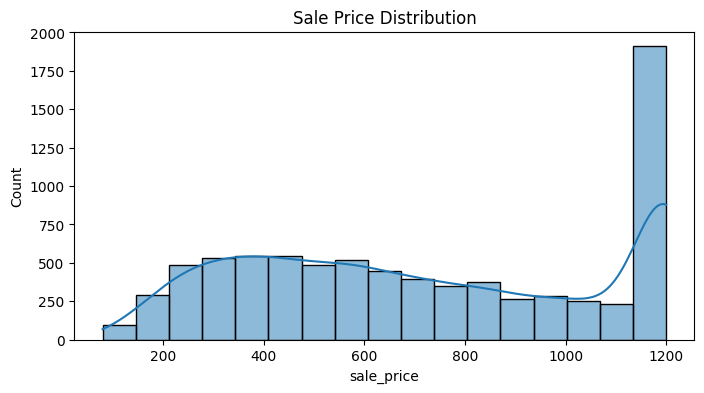

Skewness of sale price: 0.07300029773629817


In [6]:
# Price distribution
plt.figure(figsize=(8,4))
sns.histplot(df['sale_price'], kde=True)
plt.title("Sale Price Distribution")
plt.show()

# Skewness
print("Skewness of sale price:", df['sale_price'].skew())


In [7]:
# Correlation heatmap (using only numeric columns)
plt.figure(figsize=(14, 10))
numeric_df = df.select_dtypes(include=['float64', 'int64'])  # Only numeric data
sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Label encode categorical variables
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Drop missing values
df = df.dropna()

# Handle outliers in sale_price (remove top/bottom 1%)
q_low = df['sale_price'].quantile(0.01)
q_high = df['sale_price'].quantile(0.99)
df = df[(df['sale_price'] > q_low) & (df['sale_price'] < q_high)]

# Split features and target
X = df.drop('sale_price', axis=1)
y = df['sale_price']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create PyTorch dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [10]:
import torch.nn as nn

# Define the model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x)

# Initialize model, loss function, optimizer
model = RegressionModel(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 20, Loss: 408056.9688
Epoch 40, Loss: 429292.3125
Epoch 60, Loss: 336730.4688
Epoch 80, Loss: 296311.6562
Epoch 100, Loss: 376584.8438


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate on test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)

# Convert predictions to NumPy
y_pred_np = y_pred_test.numpy().flatten()
y_true_np = y_test_tensor.numpy().flatten()

# Calculate metrics
mae = mean_absolute_error(y_true_np, y_pred_np)
mse = mean_squared_error(y_true_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_np, y_pred_np)

print("\n📊 Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")



📊 Evaluation Metrics:
MAE: 528.00
MSE: 328353.91
RMSE: 573.02
R² Score: -3.2750


In [12]:
# Residuals plot
residuals = y_true_np - y_pred_np

plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()
